Обучение модели InceptionNetV3

Found 4400 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6554 - loss: 0.8755 
Epoch 1: val_accuracy improved from -inf to 0.83636, saving model to /content/drive/MyDrive/new_inceptionnetV3.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 2185s 15s/step - accuracy: 0.6564 - loss: 0.8732 - val_accuracy: 0.8364 - val_loss: 0.5216
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9345 - loss: 0.1931
Epoch 2: val_accuracy improved from 0.83636 to 0.92909, saving model to /content/drive/MyDrive/new_inceptionnetV3.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.9345 - loss: 0.1930 - val_accuracy: 0.9291 - val_loss: 0.2452
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9671 - loss: 0.1132
Epoch 3: val_accuracy improved from 0.92909 to 0.95636, saving model to /content/drive/MyDrive/new_inceptionnetV3.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9671 - loss: 0.1133 - val_accuracy: 0.9564 - val_loss: 0.1515
Epoch 4/15
138/138 ━━━━━━━━━━━

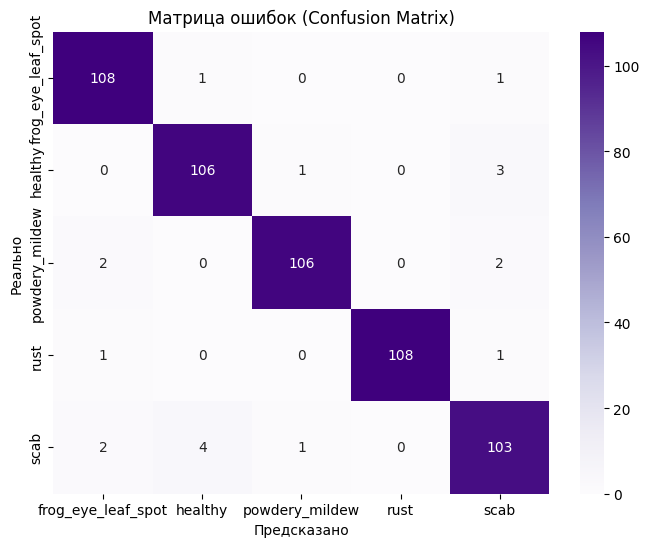

                    precision    recall  f1-score   support

frog_eye_leaf_spot       0.96      0.98      0.97       110
           healthy       0.95      0.96      0.96       110
    powdery_mildew       0.98      0.96      0.97       110
              rust       1.00      0.98      0.99       110
              scab       0.94      0.94      0.94       110

          accuracy                           0.97       550
         macro avg       0.97      0.97      0.97       550
      weighted avg       0.97      0.97      0.97       550



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 0. Фиксация Seed (для защиты)
tf.random.set_seed(42)
np.random.seed(42)

# 1. Пути
base_path = '/content/drive/MyDrive/plant_dataset_split/'

# 2. Генераторы с АУГМЕНТАЦИЕЙ
# Тренировочный генератор: добавляем вращение, сдвиги и отражение
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Валидационный генератор: ТОЛЬКО предобработка (нельзя аугментировать проверочные данные)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    base_path + 'train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    base_path + 'val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # Важно для матрицы ошибок!
)

# 3. Модель
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = True # Оставляем True для Fine-tuning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4), # Защита от переобучения
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Сохранение (назовем модель по-новому)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/new_inceptionnetV3.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# 5. Обучение
history = model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[checkpoint, early_stop])

# 6. ГРАФИКИ


# 7. НОВЫЙ БЛОК: Матрица ошибок
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Purples')
plt.xlabel('Предсказано')
plt.ylabel('Реально')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))